# Fully connected networks

In the previous notebook, you implemented a simple two-layer neural network class.  However, this class is not modular.  If you wanted to change the number of layers, you would need to write a new loss and gradient function.  If you wanted to optimize the network with different optimizers, you'd need to write new training functions.  If you wanted to incorporate regularizations, you'd have to modify the loss and gradient function.  

Instead of having to modify functions each time, for the rest of the class, we'll work in a more modular framework where we define forward and backward layers that calculate losses and gradients respectively.  Since the forward and backward layers share intermediate values that are useful for calculating both the loss and the gradient, we'll also have these function return "caches" which store useful intermediate values.

The goal is that through this modular design, we can build different sized neural networks for various applications.

In this HW #3, we'll define the basic architecture, and in HW #4, we'll build on this framework to implement different optimizers and regularizations (like BatchNorm and Dropout).



## Modular layers

This notebook will build modular layers in the following manner.  First, there will be a forward pass for a given layer with inputs (`x`) and return the output of that layer (`out`) as well as cached variables (`cache`) that will be used to calculate the gradient in the backward pass.

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

In [2]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Linear layers

In this section, we'll implement the forward and backward pass for the linear layers.

The linear layer forward pass is the function `affine_forward` in `nndl/layers.py` and the backward pass is `affine_backward`.

After you have implemented these, test your implementation by running the cell below.

### Affine layer forward pass

Implement `affine_forward` and then test your code by running the following cell.

In [12]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: {}'.format(rel_error(out, correct_out)))

Testing affine_forward function:
difference: 9.769848888397517e-10


### Affine layer backward pass

Implement `affine_backward` and then test your code by running the following cell.

In [13]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: {}'.format(rel_error(dx_num, dx)))
print('dw error: {}'.format(rel_error(dw_num, dw)))
print('db error: {}'.format(rel_error(db_num, db)))

Testing affine_backward function:
dx error: 7.563194788327602e-10
dw error: 3.197701413621418e-11
db error: 1.012939801121949e-11


## Activation layers

In this section you'll implement the ReLU activation.

### ReLU forward pass

Implement the `relu_forward` function in `nndl/layers.py` and then test your code by running the following cell.

In [14]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: {}'.format(rel_error(out, correct_out)))

Testing relu_forward function:
difference: 4.999999798022158e-08


### ReLU backward pass
Implement the `relu_backward` function in `nndl/layers.py` and then test your code by running the following cell.

In [15]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: {}'.format(rel_error(dx_num, dx)))

Testing relu_backward function:
dx error: 3.27561779540815e-12


## Combining the affine and ReLU layers

Often times, an affine layer will be followed by a ReLU layer. So let's make one that puts them together.  Layers that are combined are stored in `nndl/layer_utils.py`.  

### Affine-ReLU layers
We've implemented `affine_relu_forward()` and `affine_relu_backward` in ``nndl/layer_utils.py``.  Take a look at them to make sure you understand what's going on.  Then run the following cell to ensure its implemented correctly.

In [16]:
from nndl.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: {}'.format(rel_error(dx_num, dx)))
print('dw error: {}'.format(rel_error(dw_num, dw)))
print('db error: {}'.format(rel_error(db_num, db)))

Testing affine_relu_forward and affine_relu_backward:
dx error: 3.224550727822918e-10
dw error: 9.644682245165236e-10
db error: 1.4845082700378478e-11


## Softmax losses

You've already implemented it, so we have written it in `layers.py`.  The following code will ensure its working correctly.

In [17]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)



dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: {}'.format(loss))
print('dx error: {}'.format(rel_error(dx_num, dx)))


Testing softmax_loss:
loss: 2.3024575291692395
dx error: 7.666269598435665e-09


## Implementation of a two-layer NN

In `nndl/fc_net.py`, implement the class `TwoLayerNet` which uses the layers you made here.  When you have finished, the following cell will test your implementation.

In [19]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dims=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = {}'.format(reg))
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg = 0.0
W1 relative error: 1.5215703686475096e-08
W2 relative error: 3.2068321167375225e-10
b1 relative error: 6.5485457079879785e-09
b2 relative error: 4.3291360264321544e-10
Running numeric gradient check with reg = 0.7
W1 relative error: 2.527915175868136e-07
W2 relative error: 2.8508510893102143e-08
b1 relative error: 1.5646801536371197e-08
b2 relative error: 7.759095355706557e-10


## Solver 

We will now use the utils Solver class to train these networks.  Familiarize yourself with the API in `utils/solver.py`.  After you have done so, declare an instance of a TwoLayerNet with 200 units and then train it with the Solver.  Choose parameters so that your validation accuracy is at least 50%.

In [4]:
model = TwoLayerNet()
solver = None

# ================================================================ #
# YOUR CODE HERE:
#   Declare an instance of a TwoLayerNet and then train 
#   it with the Solver. Choose hyperparameters so that your validation 
#   accuracy is at least 50%.  We won't have you optimize this further
#   since you did it in the previous notebook.
#
# ================================================================ #

model =  TwoLayerNet(hidden_dims=200,reg =0.1)
solver = Solver(model,data,update_rule='sgd',
                  optim_config={
                    'learning_rate': 0.0006309573444801943,
                  },
                  lr_decay=0.95,
                  num_epochs=10, batch_size=200,
                  print_every=100)
solver.train()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

(Iteration 1 / 2450) loss: 2.339052
(Epoch 0 / 10) train acc: 0.125000; val_acc: 0.121000
(Iteration 101 / 2450) loss: 1.889397
(Iteration 201 / 2450) loss: 1.778808
(Epoch 1 / 10) train acc: 0.427000; val_acc: 0.404000
(Iteration 301 / 2450) loss: 1.541907
(Iteration 401 / 2450) loss: 1.729550
(Epoch 2 / 10) train acc: 0.489000; val_acc: 0.457000
(Iteration 501 / 2450) loss: 1.752704
(Iteration 601 / 2450) loss: 1.516647
(Iteration 701 / 2450) loss: 1.525637
(Epoch 3 / 10) train acc: 0.498000; val_acc: 0.459000
(Iteration 801 / 2450) loss: 1.468848
(Iteration 901 / 2450) loss: 1.393098
(Epoch 4 / 10) train acc: 0.509000; val_acc: 0.473000
(Iteration 1001 / 2450) loss: 1.491403
(Iteration 1101 / 2450) loss: 1.514397
(Iteration 1201 / 2450) loss: 1.356083
(Epoch 5 / 10) train acc: 0.503000; val_acc: 0.500000
(Iteration 1301 / 2450) loss: 1.393551
(Iteration 1401 / 2450) loss: 1.345242
(Epoch 6 / 10) train acc: 0.530000; val_acc: 0.500000
(Iteration 1501 / 2450) loss: 1.280603
(Iteration

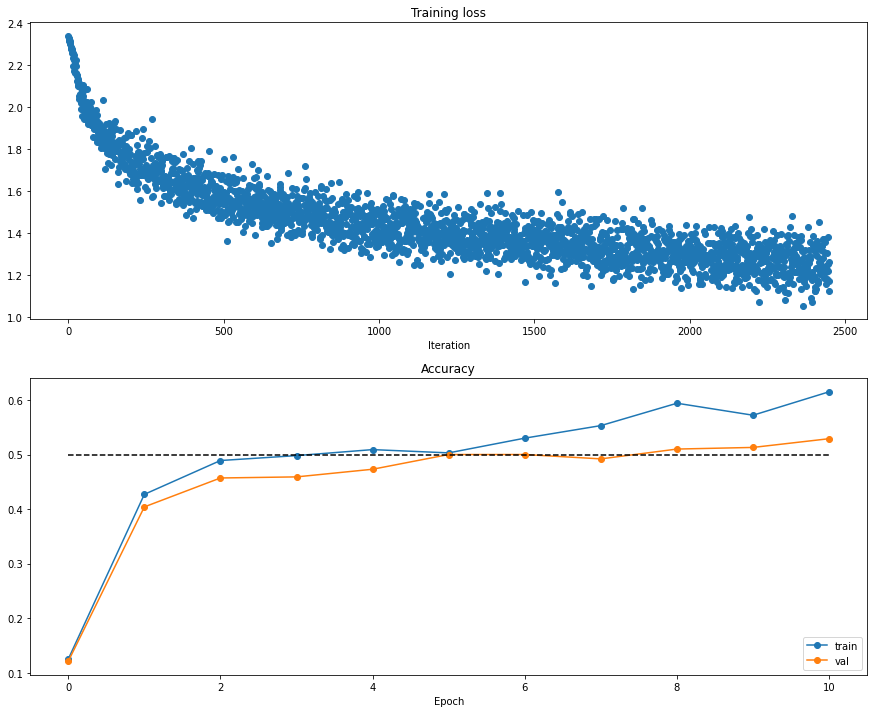

In [5]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

## Multilayer Neural Network

Now, we implement a multi-layer neural network.

Read through the `FullyConnectedNet` class in the file `nndl/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass.  There will be lines for batchnorm and dropout layers and caches; ignore these all for now.  That'll be in HW #4.

In [28]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = {}'.format(reg))
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: {}'.format(loss))

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))

Running check with reg = 0
1
2
3
Initial loss: 2.299347715164168
W1 relative error: 2.3514658857225252e-07
W2 relative error: 6.100204645916527e-07
W3 relative error: 1.745421999062609e-07
b1 relative error: 9.15094459331774e-09
b2 relative error: 5.26449194179833e-09
b3 relative error: 1.157414535016805e-10
Running check with reg = 3.14
1
2
3
Initial loss: 7.127044653398778
W1 relative error: 1.8756361897261136e-08
W2 relative error: 2.5180746658232636e-08
W3 relative error: 8.804986555515399e-09
b1 relative error: 1.1505316744282954e-07
b2 relative error: 1.0988182231388104e-08
b3 relative error: 2.9898122817337374e-10


1
2
3
(Iteration 1 / 40) loss: 2.294310
(Epoch 0 / 20) train acc: 0.300000; val_acc: 0.131000
(Epoch 1 / 20) train acc: 0.420000; val_acc: 0.149000
(Epoch 2 / 20) train acc: 0.540000; val_acc: 0.163000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.162000
(Epoch 4 / 20) train acc: 0.620000; val_acc: 0.153000
(Epoch 5 / 20) train acc: 0.660000; val_acc: 0.184000
(Iteration 11 / 40) loss: 1.213256
(Epoch 6 / 20) train acc: 0.800000; val_acc: 0.200000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.165000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.186000
(Epoch 9 / 20) train acc: 0.820000; val_acc: 0.191000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.199000
(Iteration 21 / 40) loss: 0.530831
(Epoch 11 / 20) train acc: 0.860000; val_acc: 0.165000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.193000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.193000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.201000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.193000
(Iteration 31 / 40) 

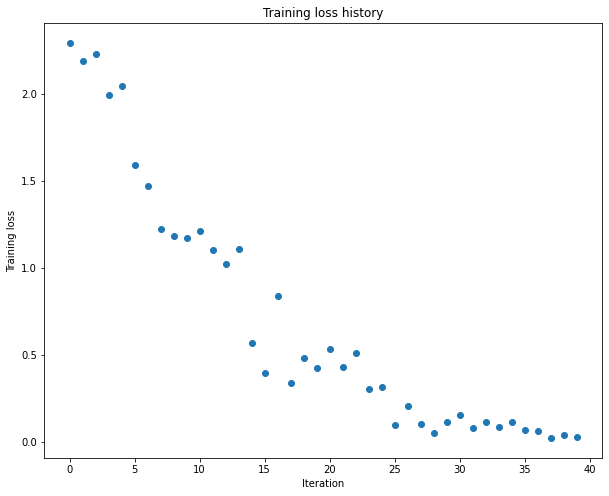

In [31]:
# Use the three layer neural network to overfit a small dataset.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


#### !!!!!!
# Play around with the weight_scale and learning_rate so that you can overfit a small dataset.
# Your training accuracy should be 1.0 to receive full credit on this part.
weight_scale = 1e-2
learning_rate = 1e-2

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## layers.py

In [ ]:
import numpy as np
import pdb




def affine_forward(x, w, b):
  """
  Computes the forward pass for an affine (fully-connected) layer.

  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k). We will
  reshape each input into a vector of dimension D = d_1 * ... * d_k, and
  then transform it to an output vector of dimension M.

  Inputs:
  - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
  - w: A numpy array of weights, of shape (D, M)
  - b: A numpy array of biases, of shape (M,)
  
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """

  # ================================================================ #
  # YOUR CODE HERE:
  #   Calculate the output of the forward pass.  Notice the dimensions
  #   of w are D x M, which is the transpose of what we did in earlier 
  #   assignments.
  # ================================================================ #

  x1 = x.reshape(x.shape[0], -1)
  
  out =np.dot(x1,w) + b
  

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
    
  cache = (x, w, b)
  return out, cache


def affine_backward(dout, cache):
  """
  Computes the backward pass for an affine layer.

  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)

  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  dx, dw, db = None, None, None

  # ================================================================ #
  # YOUR CODE HERE:
  #   Calculate the gradients for the backward pass.
  # ================================================================ #

  # dout is N x M
  # dx should be N x d1 x ... x dk; it relates to dout through multiplication with w, which is D x M
  # dw should be D x M; it relates to dout through multiplication with x, which is N x D after reshaping
  # db should be M; it is just the sum over dout examples

  x1 = x.reshape(x.shape[0], -1) 
  dw = np.dot(x1.T,dout)
  dx = np.dot(dout,w.T)
  dx = dx.reshape(x.shape)
  db = np.sum(dout,axis=0)
  
  

  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
  
  return dx, dw, db

def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).

  Input:
  - x: Inputs, of any shape

  Returns a tuple of:
  - out: Output, of the same shape as x
  - cache: x
  """
  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the ReLU forward pass.
  # ================================================================ #

  reLu = lambda x: np.maximum(x, 0)
  out  = reLu(x)
  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
 
  cache = x
  return out, cache


def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).

  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout

  Returns:
  - dx: Gradient with respect to x
  """
  x = cache

  # ================================================================ #
  # YOUR CODE HERE:
  #   Implement the ReLU backward pass
  # ================================================================ #

  # ReLU directs linearly to those > 0
  x1 = x.reshape(x.shape[0], -1)
  dx = dout * (x1 >= 0)
    
  # ================================================================ #
  # END YOUR CODE HERE
  # ================================================================ #
 
  return dx

def svm_loss(x, y):
  """
  Computes the loss and gradient using for multiclass SVM classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  N = x.shape[0]
  correct_class_scores = x[np.arange(N), y]
  margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
  margins[np.arange(N), y] = 0
  loss = np.sum(margins) / N
  num_pos = np.sum(margins > 0, axis=1)
  dx = np.zeros_like(x)
  dx[margins > 0] = 1
  dx[np.arange(N), y] -= num_pos
  dx /= N
  return loss, dx


def softmax_loss(x, y):
  """
  Computes the loss and gradient for softmax classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """

  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx


##  fc_net.py

In [ ]:
from turtle import hideturtle
import numpy as np

from .layers import *
from .layer_utils import *


class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network with ReLU nonlinearity and
  softmax loss that uses a modular layer design. We assume an input dimension
  of D, a hidden dimension of H, and perform classification over C classes.
  
  The architecure should be affine - relu - affine - softmax.

  Note that this class does not implement gradient descent; instead, it
  will interact with a separate Solver object that is responsible for running
  optimization.

  The learnable parameters of the model are stored in the dictionary
  self.params that maps parameter names to numpy arrays.
  """
  
  def __init__(self, input_dim=3*32*32, hidden_dims=100, num_classes=10,
               dropout=0, weight_scale=1e-3, reg=0.0):
    """
    Initialize a new network.

    Inputs:
    - input_dim: An integer giving the size of the input
    - hidden_dims: An integer giving the size of the hidden layer
    - num_classes: An integer giving the number of classes to classify
    - dropout: Scalar between 0 and 1 giving dropout strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - reg: Scalar giving L2 regularization strength.
    """
    self.params = {}
    self.reg = reg
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize W1, W2, b1, and b2.  Store these as self.params['W1'], 
    #   self.params['W2'], self.params['b1'] and self.params['b2']. The
    #   biases are initialized to zero and the weights are initialized
    #   so that each parameter has mean 0 and standard deviation weight_scale.
    #   The dimensions of W1 should be (input_dim, hidden_dim) and the
    #   dimensions of W2 should be (hidden_dims, num_classes)
    # ================================================================ #

    size_W1 = (input_dim, hidden_dims)
    size_W2 = (hidden_dims,num_classes)
    
    self.params['W1'] = np.random.normal(loc=0.0,scale=weight_scale,size = size_W1)
    self.params['b1'] = np.zeros(hidden_dims)
    self.params['W2'] = np.random.normal(loc=0.0,scale=weight_scale,size = size_W2)
    self.params['b2'] = np.zeros(num_classes)

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

  def loss(self, X, y=None):
    """
    Compute loss and gradient for a minibatch of data.

    Inputs:
    - X: Array of input data of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

    Returns:
    If y is None, then run a test-time forward pass of the model and return:
    - scores: Array of shape (N, C) giving classification scores, where
      scores[i, c] is the classification score for X[i] and class c.

    If y is not None, then run a training-time forward and backward pass and
    return a tuple of:
    - loss: Scalar value giving the loss
    - grads: Dictionary with the same keys as self.params, mapping parameter
      names to gradients of the loss with respect to those parameters.
    """  
    scores = None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the two-layer neural network. Store
    #   the class scores as the variable 'scores'.  Be sure to use the layers
    #   you prior implemented.
    # ================================================================ #   
    # 
    #
    W1 = self.params['W1']
    b1 = self.params['b1']
    W2 = self.params['W2']
    b2 = self.params['b2'] 

    X1 = X.reshape(X.shape[0], -1)
    H1, H1_cache = affine_relu_forward(X1,W1,b1)
    Z, Z_cache = affine_forward(H1,W2,b2)
    

    scores = Z

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # If y is None then we are in test mode so just return scores
    if y is None:
      return scores
    
    loss, grads = 0, {}
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backward pass of the two-layer neural net.  Store
    #   the loss as the variable 'loss' and store the gradients in the 
    #   'grads' dictionary.  For the grads dictionary, grads['W1'] holds
    #   the gradient for W1, grads['b1'] holds the gradient for b1, etc.
    #   i.e., grads[k] holds the gradient for self.params[k].
    #
    #   Add L2 regularization, where there is an added cost 0.5*self.reg*W^2
    #   for each W.  Be sure to include the 0.5 multiplying factor to 
    #   match our implementation.
    #
    #   And be sure to use the layers you prior implemented.
    # ================================================================ #    
    loss,dLbydZ = softmax_loss(scores,y)
    loss += 0.5*self.reg*(np.sum(W1*W1) + np.sum(W2*W2))

    dH1, dW2,db2 = affine_backward(dLbydZ,Z_cache)
    dX1, dW1,db1 = affine_relu_backward(dH1,H1_cache)
    
    grads['W1'] = dW1 + self.reg * W1
    grads['b1'] = db1
    grads['W2'] = dW2 + self.reg * W2
    grads['b2'] = db2


    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return loss, grads


class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function. This will also implement
  dropout and batch normalization as options. For a network with L layers,
  the architecture will be
  
  {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax
  
  where batch normalization and dropout are optional, and the {...} block is
  repeated L - 1 times.
  
  Similar to the TwoLayerNet above, learnable parameters are stored in the
  self.params dictionary and will be learned using the Solver class.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=0, use_batchnorm=False, reg=0.0,
               weight_scale=1e-2, dtype=np.float32, seed=None):
    """
    Initialize a new FullyConnectedNet.
    
    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
      the network should not use dropout at all.
    - use_batchnorm: Whether or not the network should use batch normalization.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - dtype: A numpy datatype object; all computations will be performed using
      this datatype. float32 is faster but less accurate, so you should use
      float64 for numeric gradient checking.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic so we can gradient check the
      model.
    """
    self.use_batchnorm = use_batchnorm
    self.use_dropout = dropout > 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.params = {}

    # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize all parameters of the network in the self.params dictionary.
    #   The weights and biases of layer 1 are W1 and b1; and in general the 
    #   weights and biases of layer i are Wi and bi. The
    #   biases are initialized to zero and the weights are initialized
    #   so that each parameter has mean 0 and standard deviation weight_scale.
    # ================================================================ #
    
    for layer_num in range(1,self.num_layers+1):
      weight_name = "W{}".format(layer_num)
      bias_name   = "b{}".format(layer_num)
      print(layer_num)
      
      #first layer
      if layer_num == 1:
        hidden_dim = hidden_dims[layer_num-1]
        size_W1 = (input_dim, hidden_dim)
        self.params[weight_name] = np.random.normal(loc=0.0,scale=weight_scale,size = size_W1)
        self.params[bias_name] = np.zeros(hidden_dim)

      #output layer
      elif layer_num == self.num_layers:
        output_layer = (hidden_dim,num_classes)
        self.params[weight_name] = np.random.normal(loc=0.0,scale=weight_scale,size = output_layer)
        self.params[bias_name] = np.zeros(num_classes)

      #middle layers
      else:
        hidden_dim = hidden_dims[layer_num-1]
        size_layer = (hidden_dims[layer_num-2], hidden_dim)
        self.params[weight_name] = np.random.normal(loc=0.0,scale=weight_scale,size = size_layer)
        self.params[bias_name] = np.zeros(hidden_dim)
        


    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # When using dropout we need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test). You can pass the same dropout_param to each dropout layer.
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed
    
    # With batch normalization we need to keep track of running means and
    # variances, so we need to pass a special bn_param object to each batch
    # normalization layer. You should pass self.bn_params[0] to the forward pass
    # of the first batch normalization layer, self.bn_params[1] to the forward
    # pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.use_batchnorm:
      self.bn_params = [{'mode': 'train'} for i in np.arange(self.num_layers - 1)]
    
    # Cast all parameters to the correct datatype
    for k, v in self.params.items():
      self.params[k] = v.astype(dtype)


  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.

    Input / output: Same as TwoLayerNet above.
    """
    X = X.astype(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.dropout_param is not None:
      self.dropout_param['mode'] = mode   
    if self.use_batchnorm:
      for bn_param in self.bn_params:
        bn_param[mode] = mode

    scores = None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the FC net and store the output
    #   scores as the variable "scores".
    # ================================================================ #

    H = []
    H_cache = []
    for layer_num in range(1,self.num_layers+1):
      weight_name = "W{}".format(layer_num)
      bias_name   = "b{}".format(layer_num)

      H_app = None
      H_cache_app = None

      if layer_num ==1:
        H_app,H_cache_app = affine_relu_forward(X,self.params[weight_name],self.params[bias_name])
        H.append(H_app)
        H_cache.append(H_cache_app)
      elif layer_num ==self.num_layers:
        scores,H_cache_app = affine_forward(H[layer_num-2],self.params[weight_name],self.params[bias_name])
        H_cache.append(H_cache_app)
      else:
        H_app,H_cache_app = affine_relu_forward(H[layer_num-2],self.params[weight_name],self.params[bias_name])
        H.append(H_app)
        H_cache.append(H_cache_app)

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = 0.0, {}
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backwards pass of the FC net and store the gradients
    #   in the grads dict, so that grads[k] is the gradient of self.params[k]
    #   Be sure your L2 regularization includes a 0.5 factor.
    # ================================================================ #
    loss,dLbydZ = softmax_loss(scores,y)
    dHs = []

    for layer_num in range(self.num_layers,0,-1):
      weight_name = "W{}".format(layer_num)
      bias_name   = "b{}".format(layer_num)
      loss += 0.5*self.reg*np.sum(self.params[weight_name]*self.params[weight_name])
   
      if layer_num ==self.num_layers:
        dH1, dW,db = affine_backward(dLbydZ,H_cache[layer_num-1])
        grads[weight_name] = dW + self.reg * self.params[weight_name]
        grads[bias_name] = db
        dHs.append(dH1)
      
      else:
        dH1, dW,db = affine_relu_backward(dH1,H_cache[layer_num-1])
        grads[weight_name] = dW + self.reg * self.params[weight_name]
        grads[bias_name] = db
        dHs.append(dH1)
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    return loss, grads
